In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings("ignore")
# from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy
from spikingjelly.datasets.n_mnist import NMNIST

In [50]:
nmnist_train = NMNIST('./data/', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('./data/', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=256, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=256, shuffle=False, drop_last=False, num_workers=0)


The directory [./data/frames_number_20_split_by_number] already exists.
The directory [./data/frames_number_20_split_by_number] already exists.


In [56]:
for img, label in train_loader:
    batch = img.shape[0]
    x = F.relu(conv1(img[:,1]))
    x = F.relu(conv2(x))
    x = x.view(batch, -1)
    print(x.shape)

torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])
torch.Size([256, 392])


KeyboardInterrupt: 

In [37]:
x = nmnist_train[1][0]
x = torch.sign(x.clamp(min=0))

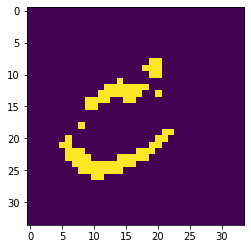

In [40]:
plt.imshow(x[0,0])

In [33]:
x[1][x[1]>0]=1

In [35]:
x[1].max()

1.0

In [48]:
conv1 = nn.Conv2d(2, 8, 3, stride=2)
conv2 = nn.Conv2d(8, 8, 3, stride=2)
y = conv1(torch.tensor(x[0]).unsqueeze(0))
conv2(y).view(1, -1)

torch.Size([1, 392])

In [62]:
'''
首次修改2023年7月13日22:10:55

'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings("ignore")
# from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy
from spikingjelly.datasets.n_mnist import NMNIST


class config:
    input = 700
    output = 20
    hid = 64         # number of RC Neurons
    thr = 0.5
    b_j0 = 0.01       # thr baseline
    dt = 1
    R_m = 1
    decay = 0.5
    rst = 0.05
    lens = 0.5
    gamma = 0.5       # gradient scale 
    gradient_type = 'G' # 'MG', 'slayer', 'linear' 窗型函数
    scale = 6.        # special for 'MG'
    hight = 0.15      # special for 'MG'

    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    # gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    input_learn = False # learnable input layer
    seed = 123
    trials = 5        # try on 5 different seeds
    batch = 512
    epoch = 100
    lr = 0.005
    l1 = 0.0003
    l1_targ = 2000
    fr_norm = 0.01
    fr_targ = 0.05
    dropout = 0.75
    dropout_stepping = 0.015
    dropout_stop = 0.95
    weight_decay = 1e-4
    label_smoothing = False
    smoothing = 0.15
    norm = False      # add layer norm before each layer
    shortcut = False
    small_init = True
    device = torch.device('cpu')

##########################################################
########### define surrogate gradient function ###########
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(torch.pi)) / sigma

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        if config.gradient_type == 'G':
            temp = torch.exp(-(input**2)/(2*config.lens**2))/torch.sqrt(2*torch.tensor(torch.pi))/config.lens
        elif config.gradient_type == 'MG':
            temp = gaussian(input, mu=0., sigma=config.lens) * (1. + config.hight) \
                - gaussian(input, mu=config.lens, sigma=config.scale * config.lens) * config.hight \
                - gaussian(input, mu=-config.lens, sigma=config.scale * config.lens) * config.hight
        elif config.gradient_type =='linear':
            temp = F.relu(1-input.abs())
        elif config.gradient_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * config.gamma
act_fun_adp = ActFun_adp.apply

#######################################
########### define RC model ###########

class RC(nn.Module):
    def __init__(self):
        super(RC, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, 3, stride=2)
        self.conv2 =  nn.Conv2d(8, 8, 3, stride=2)
        
        self.inpt_hid1 = nn.Linear(392, config.hid)
        self.hid1_hid1 = nn.Linear(config.hid, config.hid) # A1
        self.hid1_hid2 = nn.Linear(config.hid, config.hid)
        self.hid2_hid2 = nn.Linear(config.hid, config.hid) # A2
        self.hid2_out = nn.Linear(config.hid, config.output)
        if config.small_init:
            self.hid1_hid1.weight.data = 0.2 * self.hid1_hid1.weight.data
            self.hid2_hid2.weight.data = 0.2 * self.hid2_hid2.weight.data
        
        nn.init.orthogonal_(self.inpt_hid1.weight)  # 主要用以解决深度网络的梯度消失爆炸问题，在RNN中经常使用
        nn.init.orthogonal_(self.hid2_hid2.weight)
        nn.init.xavier_uniform_(self.inpt_hid1.weight) # 保持输入输出的方差一致，避免所有输出值都趋向于0。通用方法，适用于任何激活函数
        nn.init.xavier_uniform_(self.hid1_hid2.weight)
        nn.init.xavier_uniform_(self.hid2_out.weight)
        
        nn.init.constant_(self.inpt_hid1.bias, 0)
        nn.init.constant_(self.hid1_hid2.bias, 0)
        nn.init.constant_(self.hid1_hid1.bias, 0)
        nn.init.constant_(self.hid2_hid2.bias, 0)
        
        self.tau_adp_h1 = nn.Parameter(torch.Tensor(config.hid))
        self.tau_adp_h2 = nn.Parameter(torch.Tensor(config.hid))
        self.tau_adp_o = nn.Parameter(torch.Tensor(config.output))
        self.tau_m_h1 = nn.Parameter(torch.Tensor(config.hid))
        self.tau_m_h2 = nn.Parameter(torch.Tensor(config.hid))
        self.tau_m_o = nn.Parameter(torch.Tensor(config.output))
        
        nn.init.normal_(self.tau_adp_h1, 150, 10)
        nn.init.normal_(self.tau_adp_h2, 150, 10)
        nn.init.normal_(self.tau_adp_o, 150, 10)
        nn.init.normal_(self.tau_m_h1, 20., 5)
        nn.init.normal_(self.tau_m_h2, 20., 5)
        nn.init.normal_(self.tau_m_o, 20., 5)
        
        self.b_hid1 = self.b_hid2 = self.b_o = 0
        self.dp = nn.Dropout(0.1)
        
        if not config.input_learn:
            for name, p in self.named_parameters():
                if 'conv1' in name or 'conv2' in name:
                    p.requires_grad = False
    
    def output_Neuron(self, inputs, mem, tau_m, dt=1):
        """The read out neuron is leaky integrator without spike"""
        # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
        alpha = torch.exp(-1. * dt / tau_m).cuda()
        mem = mem * alpha + (1. - alpha) * config.R_m * inputs
        return mem
    
    def mem_update_adp(self, inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
        alpha = torch.exp(-1. * dt / tau_m).cuda()
        ro = torch.exp(-1. * dt / tau_adp).cuda()
        if isAdapt: beta = 1.8
        else:       beta = 0.
        b = ro * b + (1 - ro) * spike
        B = config.b_j0 + beta * b
        mem = mem * alpha + (1 - alpha) * config.R_m * inputs - B * spike * dt
        spike = act_fun_adp(mem - B)
        return mem, spike, B, b
    
    def forward(self, input, mask):
        input = torch.sign(input.clamp(min=0)) # all pixels should be 0 or 1
        batch = input.shape[0]
        time_step = input.shape[1]
        self.b_hid1 = self.b_hid2 = self.b_out = config.b_j0
        
        hid1_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(config.device)
        hid1_spk = torch.zeros(batch, config.hid).to(config.device)
        
        hid2_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(config.device)
        hid2_spk = torch.zeros(batch, config.hid).to(config.device)
        
        out_mem = torch.zeros(batch, config.output).uniform_(0, 0.1).to(config.device)
        output = torch.zeros(batch, config.output).to(config.device)
        
        sum1_spk = torch.zeros(batch, config.hid).to(config.device)
        sum2_spk = torch.zeros(batch, config.hid).to(config.device)
        
        if config.dropout>0:
            self.hid1_hid1.weight.data = self.hid1_hid1.weight.data * mask[0].T.to(config.device)
            self.hid2_hid2.weight.data = self.hid2_hid2.weight.data * mask[1].T.to(config.device)
        for t in range(time_step):
            input_t = input[:,t,:,:,:].float()
            ########## Layer 0 ##########
            x = F.relu(self.conv1(input_t))
            x = F.relu(self.conv2(x))
            x = x.view(batch, -1)
            
            
            ########## Layer 1 ##########
            inpt_hid1 = self.inpt_hid1(x) + self.hid1_hid1(hid1_spk)
            hid1_mem, hid1_spk, theta_h1, self.b_h1 = self.mem_update_adp(inpt_hid1, hid1_mem, hid1_spk, self.tau_adp_h1, self.b_hid1,self.tau_m_h1)
            sum1_spk += hid1_spk
            # hid1_spk = self.dp(hid1_spk)
            
            ########## Layer 2 ##########
            # inpt_hid2 = self.hid1_hid2(hid1_spk) + self.hid2_hid2(hid2_spk)
            # hid2_mem, hid2_spk, theta_h2, self.b_h2 = self.mem_update_adp(inpt_hid2, hid2_mem, hid2_spk, self.tau_adp_h2, self.b_hid2,self.tau_m_h2)
            # sum2_spk += hid2_spk
            # hid2_spk = self.dp(hid2_spk)
            
            ########## Layer out ########
            inpt_out = self.hid2_out(hid1_spk)
            out_mem = self.output_Neuron(inpt_out, out_mem, self.tau_m_o)
            if t > 5:
                output += F.softmax(out_mem, dim=1)
            
        sum1_spk /= time_step
        sum2_spk /= time_step

        A_norm = torch.norm(self.hid1_hid1.weight, p=1) + torch.norm(self.hid2_hid2.weight, p=1)
        return output, sum1_spk, sum1_spk, A_norm


In [63]:
model = RC().to(config.device)

In [65]:
for name, p in model.named_parameters():
    print(name, p.requires_grad)

tau_adp_h1 True
tau_adp_h2 True
tau_adp_o True
tau_m_h1 True
tau_m_h2 True
tau_m_o True
conv1.weight False
conv1.bias False
conv2.weight False
conv2.bias False
inpt_hid1.weight True
inpt_hid1.bias True
hid1_hid1.weight True
hid1_hid1.bias True
hid1_hid2.weight True
hid1_hid2.bias True
hid2_hid2.weight True
hid2_hid2.bias True
hid2_out.weight True
hid2_out.bias True
